# MNIST Neural Network from Scratch (NumPy) with Reverse Generation

## 1. Imports and Setup

In [67]:
import numpy as np
# import kagglehub
import pandas as pd
import os
import gzip
import time
import matplotlib.pyplot as plt
import requests
import zipfile
import struct # For parsing IDX files

# Ensure reproducibility (optional)
np.random.seed(42)

## 2. Data Loading and Preprocessing

MNIST IDX files already exist. Skipping download and extraction.
Loading data from IDX files...
Parsing IDX image file: mnist_data_from_zip\train-images-idx3-ubyte.gz (60000 images, 28x28)
Parsing IDX label file: mnist_data_from_zip\train-labels-idx1-ubyte.gz (60000 labels)
Parsing IDX image file: mnist_data_from_zip\t10k-images-idx3-ubyte.gz (10000 images, 28x28)
Parsing IDX label file: mnist_data_from_zip\t10k-labels-idx1-ubyte.gz (10000 labels)
Raw training data shape: (60000, 784), Labels: (60000,)
Raw test data shape: (10000, 784), Labels: (10000,)
Processed training data shape: (60000, 784), Labels: (60000, 10)
Processed test data shape: (10000, 784), Labels: (10000, 10)


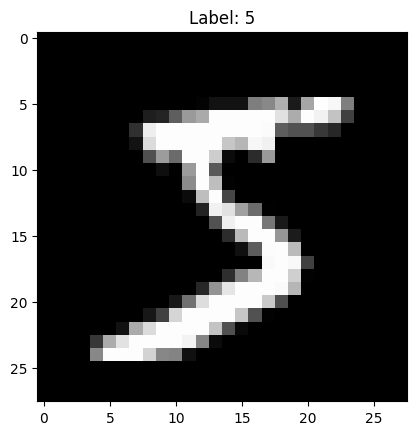

In [68]:
def download_and_extract_zip(url, save_path, extract_to='.'):
    """Downloads a zip file and extracts its contents."""
    print(f"Downloading data from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes
        with open(save_path, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=8192):
                fd.write(chunk)
        print(f"Downloaded successfully to {save_path}")

        print(f"Extracting {save_path} to {extract_to}...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete.")
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return False
    except zipfile.BadZipFile:
        print(f"Error: Downloaded file is not a valid zip file or is corrupted.")
        return False
    except Exception as e:
        print(f"An error occurred during download or extraction: {e}")
        return False

def parse_idx_file(file_path):
    """Parses an IDX file (like MNIST) into a numpy array."""
    try:
        with gzip.open(file_path, 'rb') as f:
            # Read the header
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic == 2051: # Image file
                num_rows, num_cols = struct.unpack('>II', f.read(8))
                print(f"Parsing IDX image file: {file_path} ({num_items} images, {num_rows}x{num_cols})")
                data = np.frombuffer(f.read(), dtype=np.uint8)
                data = data.reshape(num_items, num_rows * num_cols)
            elif magic == 2049: # Label file
                print(f"Parsing IDX label file: {file_path} ({num_items} labels)")
                data = np.frombuffer(f.read(), dtype=np.uint8)
            else:
                raise ValueError(f"Unknown magic number {magic} in IDX file {file_path}")
            return data
    except FileNotFoundError:
        print(f"Error: IDX file not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error parsing IDX file {file_path}: {e}")
        return None

def load_mnist_data_from_zip(zip_url):
    data_dir = 'mnist_data_from_zip'
    zip_path = os.path.join(data_dir, 'mnist.zip')
    os.makedirs(data_dir, exist_ok=True)

    # Define expected paths after extraction
    train_img_path = os.path.join(data_dir, 'train-images-idx3-ubyte.gz')
    train_lbl_path = os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')
    test_img_path = os.path.join(data_dir, 't10k-images-idx3-ubyte.gz')
    test_lbl_path = os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')

    # Check if files exist, otherwise download and extract
    if not all(os.path.exists(p) for p in [train_img_path, train_lbl_path, test_img_path, test_lbl_path]):
        if not download_and_extract_zip(zip_url, zip_path, data_dir):
            return None, None, None, None
    else:
        print("MNIST IDX files already exist. Skipping download and extraction.")

    # Parse the IDX files
    print("Loading data from IDX files...")
    X_train_raw = parse_idx_file(train_img_path)
    y_train_raw = parse_idx_file(train_lbl_path)
    X_test_raw = parse_idx_file(test_img_path)
    y_test_raw = parse_idx_file(test_lbl_path)

    if any(d is None for d in [X_train_raw, y_train_raw, X_test_raw, y_test_raw]):
        print("Failed to load one or more IDX files.")
        return None, None, None, None

    print(f"Raw training data shape: {X_train_raw.shape}, Labels: {y_train_raw.shape}")
    print(f"Raw test data shape: {X_test_raw.shape}, Labels: {y_test_raw.shape}")

    # --- Preprocessing --- (Same as before)
    # Preprocessing
    # 1. Normalize pixel values to be between 0 and 1
    X_train = X_train_raw / 255.0
    X_test = X_test_raw / 255.0

    # 2. One-hot encode labels
    num_classes = 10
    y_train = np.eye(num_classes)[y_train_raw]
    y_test = np.eye(num_classes)[y_test_raw]

    print(f"Processed training data shape: {X_train.shape}, Labels: {y_train.shape}")
    print(f"Processed test data shape: {X_test.shape}, Labels: {y_test.shape}")

    return X_train, y_train, X_test, y_test

# Load the data using the new function
MNIST_ZIP_URL = 'https://github.com/MrHeadbang/machineLearning/raw/main/mnist.zip' # Use raw link
X_train, y_train, X_test, y_test = load_mnist_data_from_zip(MNIST_ZIP_URL)

# Display a sample image (optional)
if X_train is not None:
    plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[0])}")
    plt.show()
else:
    print("Data loading failed. Cannot display sample.")

## 3. Neural Network Implementation

In [69]:
# Activation Functions
def sigmoid(z):
    # Add small epsilon to prevent overflow/underflow issues with exp
    z_clipped = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clipped))

def sigmoid_derivative(a):
    # a = sigmoid(z)
    return a * (1.0 - a)

def inverse_sigmoid(a):
    # Logit function: inverse of sigmoid
    # Clip 'a' to avoid log(0) or log(1) which are undefined/infinity
    epsilon = 1e-9
    a_clipped = np.clip(a, epsilon, 1.0 - epsilon)
    return np.log(a_clipped / (1.0 - a_clipped))

def softmax(z):
    # Subtract max for numerical stability
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Loss Function
def cross_entropy_loss(y_pred, y_true):
    # y_pred is output from softmax, y_true is one-hot encoded
    m = y_true.shape[0]
    # Clip predictions to avoid log(0)
    epsilon = 1e-9
    y_pred_clipped = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
    return loss

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        # Initialize weights and biases (Xavier/Glorot initialization)
        limit1 = np.sqrt(6 / (input_size + hidden_size1))
        self.W1 = np.random.uniform(-limit1, limit1, (input_size, hidden_size1))
        self.b1 = np.zeros((1, hidden_size1))

        limit2 = np.sqrt(6 / (hidden_size1 + hidden_size2))
        self.W2 = np.random.uniform(-limit2, limit2, (hidden_size1, hidden_size2))
        self.b2 = np.zeros((1, hidden_size2))

        limit3 = np.sqrt(6 / (hidden_size2 + output_size))
        self.W3 = np.random.uniform(-limit3, limit3, (hidden_size2, output_size))
        self.b3 = np.zeros((1, output_size))

        # Cache for backpropagation
        self.cache = {}

    def forward(self, X):
        # Input to Hidden Layer 1
        self.cache['Z1'] = X @ self.W1 + self.b1
        self.cache['A1'] = sigmoid(self.cache['Z1'])

        # Hidden Layer 1 to Hidden Layer 2
        self.cache['Z2'] = self.cache['A1'] @ self.W2 + self.b2
        self.cache['A2'] = sigmoid(self.cache['Z2'])

        # Hidden Layer 2 to Output Layer
        self.cache['Z3'] = self.cache['A2'] @ self.W3 + self.b3
        self.cache['A3'] = softmax(self.cache['Z3']) # Output activation

        return self.cache['A3']

    def backward(self, X, y_true):
        m = X.shape[0]
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        A3 = self.cache['A3'] # Output predictions

        # --- Gradients for Output Layer (Softmax + Cross-Entropy) ---
        # The derivative of Cross-Entropy Loss w.r.t Z3 (pre-activation of output)
        # when using Softmax activation is simply (A3 - y_true)
        dZ3 = (A3 - y_true) / m
        dW3 = A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # --- Gradients for Hidden Layer 2 (Sigmoid) ---
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * sigmoid_derivative(A2)
        dW2 = A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # --- Gradients for Hidden Layer 1 (Sigmoid) ---
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * sigmoid_derivative(A1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Store gradients
        self.grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

    def update_params(self, learning_rate):
        self.W1 -= learning_rate * self.grads['dW1']
        self.b1 -= learning_rate * self.grads['db1']
        self.W2 -= learning_rate * self.grads['dW2']
        self.b2 -= learning_rate * self.grads['db2']
        self.W3 -= learning_rate * self.grads['dW3']
        self.b3 -= learning_rate * self.grads['db3']

    def predict(self, X):
        # Perform forward pass and return class with highest probability
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)

    def accuracy(self, X, y_true_labels):
        # y_true_labels should be non-one-hot encoded labels (e.g., 0, 1, ..., 9)
        predictions = self.predict(X)
        return np.mean(predictions == y_true_labels)

    def train(self, X_train, y_train, X_test, y_test_labels, epochs, learning_rate, batch_size):
        # y_test_labels should be non-one-hot encoded
        m = X_train.shape[0]
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        print(f"Starting training for {epochs} epochs...")
        start_time = time.time()

        for epoch in range(epochs):
            epoch_start_time = time.time()
            # Shuffle training data
            permutation = np.random.permutation(m)
            X_shuffled = X_train[permutation]
            y_shuffled = y_train[permutation]

            epoch_loss = 0
            for i in range(0, m, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Compute loss
                loss = cross_entropy_loss(y_pred, y_batch)
                epoch_loss += loss * X_batch.shape[0] # Weighted by batch size

                # Backward pass
                self.backward(X_batch, y_batch)

                # Update parameters
                self.update_params(learning_rate)

            # Calculate metrics for the epoch
            avg_epoch_loss = epoch_loss / m
            train_accuracy = self.accuracy(X_train, np.argmax(y_train, axis=1))

            # Validation metrics
            val_pred = self.forward(X_test)
            val_loss = cross_entropy_loss(val_pred, np.eye(self.output_size)[y_test_labels]) # Use original non-one-hot test labels
            val_accuracy = self.accuracy(X_test, y_test_labels)

            history['loss'].append(avg_epoch_loss)
            history['accuracy'].append(train_accuracy)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            epoch_time = time.time() - epoch_start_time
            print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - loss: {avg_epoch_loss:.4f} - acc: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_accuracy:.4f}")

        total_time = time.time() - start_time
        print(f"Training finished in {total_time:.2f}s")
        return history

# --- Instantiate the Network (if data loaded successfully) ---
if X_train is not None:
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    hidden_dim1 = 128
    hidden_dim2 = 64

    nn = NeuralNetwork(input_size=input_dim,
                       hidden_size1=hidden_dim1,
                       hidden_size2=hidden_dim2,
                       output_size=output_dim)
    print("Neural Network Initialized.")
    print(f"Architecture: Input({input_dim}) -> Hidden1({hidden_dim1}) -> Hidden2({hidden_dim2}) -> Output({output_dim})")
else:
    print("Cannot initialize network because data loading failed.")
    nn = None # Set nn to None if initialization fails

Neural Network Initialized.
Architecture: Input(784) -> Hidden1(128) -> Hidden2(64) -> Output(10)


## 4. Training the Network

Starting training for 15 epochs...
Epoch 1/15 - 2.47s - loss: 1.2618 - acc: 0.8520 - val_loss: 0.5601 - val_acc: 0.8583
Epoch 2/15 - 2.40s - loss: 0.4471 - acc: 0.8967 - val_loss: 0.3628 - val_acc: 0.8988
Epoch 3/15 - 2.37s - loss: 0.3435 - acc: 0.9072 - val_loss: 0.3084 - val_acc: 0.9099
Epoch 4/15 - 2.36s - loss: 0.3030 - acc: 0.9153 - val_loss: 0.2855 - val_acc: 0.9163
Epoch 5/15 - 2.24s - loss: 0.2763 - acc: 0.9225 - val_loss: 0.2632 - val_acc: 0.9251
Epoch 6/15 - 2.23s - loss: 0.2546 - acc: 0.9287 - val_loss: 0.2407 - val_acc: 0.9288
Epoch 7/15 - 2.24s - loss: 0.2359 - acc: 0.9353 - val_loss: 0.2233 - val_acc: 0.9358
Epoch 8/15 - 2.46s - loss: 0.2193 - acc: 0.9403 - val_loss: 0.2094 - val_acc: 0.9391
Epoch 9/15 - 2.24s - loss: 0.2046 - acc: 0.9424 - val_loss: 0.1972 - val_acc: 0.9420
Epoch 10/15 - 2.24s - loss: 0.1914 - acc: 0.9458 - val_loss: 0.1872 - val_acc: 0.9442
Epoch 11/15 - 2.28s - loss: 0.1797 - acc: 0.9511 - val_loss: 0.1756 - val_acc: 0.9475
Epoch 12/15 - 2.31s - loss: 

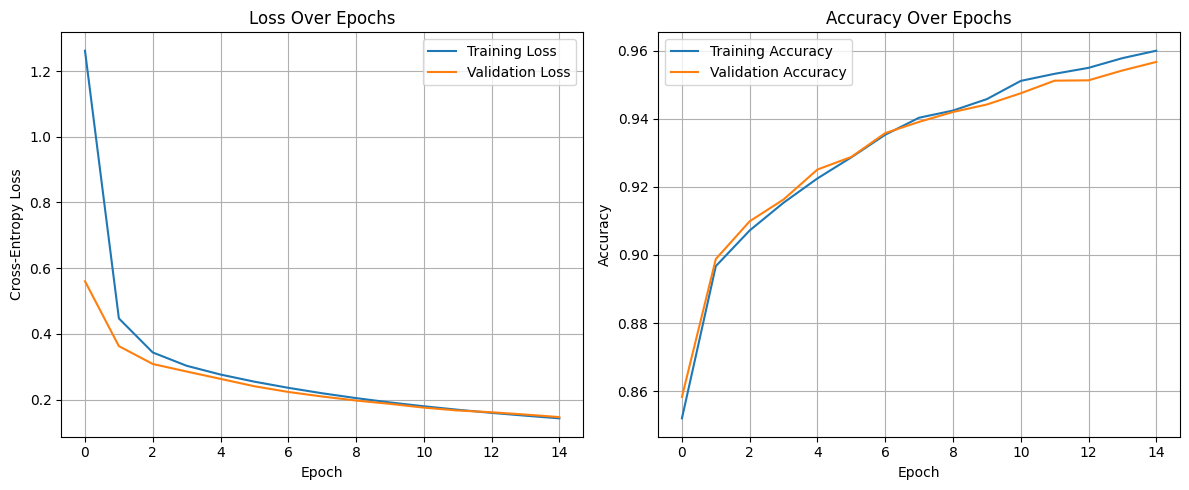

In [70]:
# Training Hyperparameters
EPOCHS = 15 # Adjust as needed
LEARNING_RATE = 0.1 # Adjust as needed
BATCH_SIZE = 64    # Adjust as needed

training_history = None
if nn is not None and X_train is not None:
    # Need the original non-one-hot test labels for accuracy calculation inside train()
    # We can get them back from the one-hot encoded y_test
    y_test_labels_int = np.argmax(y_test, axis=1)

    training_history = nn.train(X_train, y_train, X_test, y_test_labels_int,
                                EPOCHS, LEARNING_RATE, BATCH_SIZE)

    # Plot training history
    if training_history:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Plot Loss
        ax[0].plot(training_history['loss'], label='Training Loss')
        ax[0].plot(training_history['val_loss'], label='Validation Loss')
        ax[0].set_title('Loss Over Epochs')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Cross-Entropy Loss')
        ax[0].legend()
        ax[0].grid(True)

        # Plot Accuracy
        ax[1].plot(training_history['accuracy'], label='Training Accuracy')
        ax[1].plot(training_history['val_accuracy'], label='Validation Accuracy')
        ax[1].set_title('Accuracy Over Epochs')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        ax[1].grid(True)

        plt.tight_layout()
        plt.show()
else:
    print("Skipping training as the network or data was not initialized properly.")

## 5. Reverse Generation (Image from Probabilities)

In [71]:
def generate_image_from_probs(network, target_probs, rcond=1e-5):
    """Generates an input image given target output probabilities using least squares.

    Args:
        network: The trained NeuralNetwork object.
        target_probs: A 1D numpy array or list of 10 target probabilities (summing to 1).
        rcond: Cut-off ratio for small singular values in lstsq.

    Returns:
        A 1D numpy array (784,) representing the generated image pixels (0-1),
        or None if generation fails.
    """
    if network is None:
        print("Error: Network not trained or initialized.")
        return None

    target_probs = np.array(target_probs).reshape(1, network.output_size)
    if not np.isclose(np.sum(target_probs), 1.0):
        print("Error: Target probabilities must sum to 1.")
        return None

    print(f"Attempting to generate image for target probabilities: {target_probs}")

    # --- Step 1: Estimate Z3 (pre-activation of output layer) from target_probs (A3) ---
    # Softmax inverse is tricky. We approximate Z3 using log. This is a simplification.
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-9
    target_probs_clipped = np.clip(target_probs, epsilon, 1.0)
    # We take log, but Z3 isn't necessarily centered. This is an approximation.
    Z3_est = np.log(target_probs_clipped)
    # Alternative: Could try setting one Z high and others low, but log is simpler start.
    print(f"Estimated Z3 (pre-softmax): {Z3_est.shape}")

    # --- Step 2: Estimate A2 (activation of hidden layer 2) from Z3_est ---
    # We want A2 @ W3 + b3 ≈ Z3_est  =>  A2 @ W3 ≈ Z3_est - b3
    # Solve W3.T @ A2.T ≈ (Z3_est - b3).T using least squares for A2.T
    target_Z3_minus_b3 = Z3_est - network.b3
    try:
        A2_T_est, res_A2, rank_A2, s_A2 = np.linalg.lstsq(network.W3.T, target_Z3_minus_b3.T, rcond=rcond)
        A2_est = A2_T_est.T
        print(f"Estimated A2 (Hidden 2 Activation): {A2_est.shape}, Lstsq Residual: {res_A2}")
        # Clip A2 to valid sigmoid range (0, 1) - crucial!
        A2_est = np.clip(A2_est, epsilon, 1.0 - epsilon)
    except np.linalg.LinAlgError as e:
        print(f"Least squares failed for A2: {e}")
        return None

    # --- Step 3: Estimate Z2 (pre-activation of hidden layer 2) from A2_est ---
    # Use inverse sigmoid (logit)
    Z2_est = inverse_sigmoid(A2_est)
    print(f"Estimated Z2 (Pre-Sigmoid Hidden 2): {Z2_est.shape}")

    # --- Step 4: Estimate A1 (activation of hidden layer 1) from Z2_est ---
    # We want A1 @ W2 + b2 ≈ Z2_est  =>  A1 @ W2 ≈ Z2_est - b2
    # Solve W2.T @ A1.T ≈ (Z2_est - b2).T using least squares for A1.T
    target_Z2_minus_b2 = Z2_est - network.b2
    try:
        A1_T_est, res_A1, rank_A1, s_A1 = np.linalg.lstsq(network.W2.T, target_Z2_minus_b2.T, rcond=rcond)
        A1_est = A1_T_est.T
        print(f"Estimated A1 (Hidden 1 Activation): {A1_est.shape}, Lstsq Residual: {res_A1}")
        # Clip A1 to valid sigmoid range (0, 1)
        A1_est = np.clip(A1_est, epsilon, 1.0 - epsilon)
    except np.linalg.LinAlgError as e:
        print(f"Least squares failed for A1: {e}")
        return None

    # --- Step 5: Estimate Z1 (pre-activation of hidden layer 1) from A1_est ---
    # Use inverse sigmoid (logit)
    Z1_est = inverse_sigmoid(A1_est)
    print(f"Estimated Z1 (Pre-Sigmoid Hidden 1): {Z1_est.shape}")

    # --- Step 6: Estimate X_gen (input image) from Z1_est ---
    # We want X_gen @ W1 + b1 ≈ Z1_est  =>  X_gen @ W1 ≈ Z1_est - b1
    # Solve W1.T @ X_gen.T ≈ (Z1_est - b1).T using least squares for X_gen.T
    target_Z1_minus_b1 = Z1_est - network.b1
    try:
        X_gen_T_est, res_X, rank_X, s_X = np.linalg.lstsq(network.W1.T, target_Z1_minus_b1.T, rcond=rcond)
        X_gen_est = X_gen_T_est.T
        print(f"Estimated X_gen (Input Image): {X_gen_est.shape}, Lstsq Residual: {res_X}")
    except np.linalg.LinAlgError as e:
        print(f"Least squares failed for X_gen: {e}")
        return None

    # --- Step 7: Post-process the generated image ---
    # Clip the values to be in the valid pixel range [0, 1]
    X_gen_clipped = np.clip(X_gen_est, 0.0, 1.0)

    return X_gen_clipped.flatten() # Return as a 1D array

## 5.1 Zero-Gradient Backpropagation for Image Generation

In [72]:
def generate_image_zero_gradient(network, target_probabilities, learning_rate=0.1, iterations=2000,
                               regularization=0.0001, target_class=None, verbose=True):
    """Generate an input image through gradient descent to match target output probabilities.

    Args:
        network: The trained NeuralNetwork object
        target_probabilities: A 1D numpy array of 10 target probabilities (should sum to 1)
        learning_rate: Learning rate for gradient descent (default 0.1)
        iterations: Number of optimization iterations (default 2000)
        regularization: L2 regularization strength for image smoothness (default 0.0001)
        target_class: Optional target class index (0-9) for logging/display purposes
        verbose: Whether to print progress (default True)

    Returns:
        A numpy array representing the generated image (784 pixels, values 0-1)
    """
    if network is None:
        print("Error: Network not trained or initialized.")
        return None

    # Reshape and validate target probabilities
    target_probs = np.array(target_probabilities).reshape(1, -1)
    if not np.isclose(np.sum(target_probs), 1.0, rtol=1e-4):
        print(f"Warning: Target probabilities sum to {np.sum(target_probs)}, not 1.0. Normalizing...")
        target_probs = target_probs / np.sum(target_probs)

    # Initialize random image with small values (0.5 with small noise)
    image = np.random.normal(0.5, 0.01, (1, network.input_size))
    image = np.clip(image, 0.0, 1.0)  # Ensure valid pixel range

    if verbose:
        print(f"Target probabilities: {target_probs.flatten()}")
        print(f"Starting optimization for {iterations} iterations...")

    best_image = None
    best_loss = float('inf')

    # Track loss history for plotting
    loss_history = []
    probability_history = []

    for i in range(iterations):
        # Forward pass through network
        # Layer 1
        Z1 = image @ network.W1 + network.b1
        A1 = sigmoid(Z1)
        
        # Layer 2
        Z2 = A1 @ network.W2 + network.b2
        A2 = sigmoid(Z2)
        
        # Output layer
        Z3 = A2 @ network.W3 + network.b3
        A3 = softmax(Z3)  # Output probabilities

        # Compute loss - cross entropy between target and actual probabilities
        epsilon = 1e-9
        cross_entropy = -np.sum(target_probs * np.log(A3 + epsilon))
        
        # L2 regularization on image for smoothness (optional)
        reg_term = regularization * np.sum(image ** 2)
        
        # Total loss
        loss = cross_entropy + reg_term
        loss_history.append(loss)
        probability_history.append(A3.flatten()[target_class] if target_class is not None else 0)
        
        # Save best image so far
        if loss < best_loss:
            best_loss = loss
            best_image = image.copy()
        
        # Backpropagation to update the input image
        # Output layer error (A3 - target_probs)
        dZ3 = A3 - target_probs
        
        # Backpropagate to hidden layer 2
        dA2 = dZ3 @ network.W3.T
        dZ2 = dA2 * sigmoid_derivative(A2)
        
        # Backpropagate to hidden layer 1
        dA1 = dZ2 @ network.W2.T
        dZ1 = dA1 * sigmoid_derivative(A1)
        
        # Gradient with respect to input image
        dImage = dZ1 @ network.W1.T
        
        # Add regularization gradient
        dImage += 2 * regularization * image
        
        # Update the input image using gradient descent
        image -= learning_rate * dImage
        
        # Ensure image values stay within valid range (0-1)
        image = np.clip(image, 0.0, 1.0)
        
        # Print progress periodically
        if verbose and (i == 0 or (i+1) % 100 == 0 or i == iterations-1):
            target_digit = target_class if target_class is not None else np.argmax(target_probs)
            current_probs = A3.flatten()
            print(f"Iteration {i+1}/{iterations}, Loss: {loss:.4f}, "
                  f"Target prob: {current_probs[target_digit]:.4f}, "
                  f"Predicted: {np.argmax(current_probs)}")

    # Use the best image found during optimization
    final_image = best_image.flatten()
    
    # Verify final output probabilities
    final_probs = network.forward(final_image.reshape(1, -1)).flatten()
    if verbose:
        print("\nOptimization complete!")
        print(f"Final probabilities: {final_probs}")
        print(f"Predicted digit: {np.argmax(final_probs)}")
        if target_class is not None:
            print(f"Target probability for digit {target_class}: {final_probs[target_class]:.4f}")
    
    # Plot loss history and target probability if requested
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Loss During Optimization')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)

    if target_class is not None:
        plt.subplot(1, 2, 2)
        plt.plot(probability_history)
        plt.title(f'Probability for Target Class {target_class}')
        plt.xlabel('Iteration')
        plt.ylabel('Probability')
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

    return final_image

## 6. Testing Reverse Generation


--- Generating image for target probabilities ---
Target Vector (sum=1.00):
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Attempting to generate image for target probabilities: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Estimated Z3 (pre-softmax): (1, 10)
Estimated A2 (Hidden 2 Activation): (1, 64), Lstsq Residual: []
Estimated Z2 (Pre-Sigmoid Hidden 2): (1, 64)
Estimated A1 (Hidden 1 Activation): (1, 128), Lstsq Residual: []
Estimated Z1 (Pre-Sigmoid Hidden 1): (1, 128)
Estimated X_gen (Input Image): (1, 784), Lstsq Residual: []
Generated image resized to 512x512 and saved as output_512x512.png


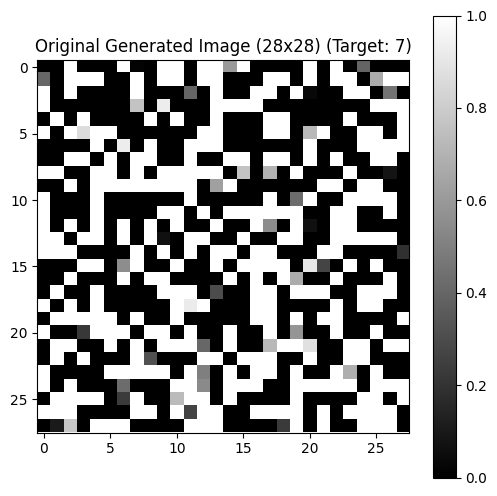


--- Verification: Probabilities from ORIGINAL generated image ---
Predicted digit: 3
Output probabilities:
[1.44503558e-02 2.18599229e-04 1.67997255e-02 5.25889893e-01
 1.88131624e-05 3.51810404e-01 5.73859826e-05 1.06720592e-04
 9.05111813e-02 1.36922189e-04]


In [73]:
# Assuming generate_image_from_probs and the NeuralNetwork class (nn) are defined elsewhere
# Assuming nn and training_history are not None

# --- Test the Reverse Generation ---
if nn is not None and training_history is not None: # Ensure network is trained
    # Example: Target digit 7 with high probability
    target_digit = 7
    high_prob = 1.0
    low_prob = (1.0 - high_prob) / (nn.output_size - 1)

    target_vector = np.full((nn.output_size,), low_prob)
    target_vector[target_digit] = high_prob

    print(f"\n--- Generating image for target probabilities ---")
    print(f"Target Vector (sum={np.sum(target_vector):.2f}):\n{target_vector}")

    # Generate the image
    generated_image_pixels = generate_image_from_probs(nn, target_vector, rcond=1e-4)

    if generated_image_pixels is not None and Image is not None: # Check if generation succeeded and Pillow is available
        # Reshape to 28x28
        generated_image_28x28 = generated_image_pixels.reshape(28, 28)

        # --- Resize and Save the image using Pillow ---
        try:
            # Normalize/Scale data to 0-255 for an 8-bit grayscale image.
            # We assume generated_image_28x28 values are roughly in [0, 1] range.
            # If not, adjust scaling (e.g., use min-max normalization first).
            min_val, max_val = np.min(generated_image_28x28), np.max(generated_image_28x28)
            if max_val > min_val: # Avoid division by zero if image is flat
                 normalized_image = (generated_image_28x28 - min_val) / (max_val - min_val)
            else:
                 normalized_image = np.zeros_like(generated_image_28x28) # Handle flat image case

            image_data_scaled = (normalized_image * 255).astype(np.uint8)

            # Create PIL Image from numpy array ('L' mode is for 8-bit grayscale)
            pil_image = Image.fromarray(image_data_scaled, mode='L')

            # Resize the image to 512x512
            # Resampling methods: NEAREST, BILINEAR, BICUBIC, LANCZOS, HAMMING
            # NEAREST is fastest, blocky. BICUBIC/LANCZOS are smoother, better for upscaling.
            resized_image = pil_image.resize((512, 512), Image.Resampling.BICUBIC)

            # Save the resized image
            output_filename = 'output_512x512.png'
            resized_image.save(output_filename)
            print(f"Generated image resized to 512x512 and saved as {output_filename}")

        except Exception as e:
            print(f"Error resizing or saving image with Pillow: {e}")
        # --- End of resizing/saving block ---

        # --- Display the ORIGINAL (28x28) image (optional) ---
        plt.figure(figsize=(6, 6))
        # Display the original 28x28 for comparison/verification
        plt.imshow(generated_image_28x28, cmap='gray')
        plt.title(f"Original Generated Image (28x28) (Target: {target_digit})")
        plt.colorbar()
        plt.show()
        # --- End of display block ---


        # Optional: Feed the ORIGINAL generated image back through the network
        if nn is not None:
            # Use the original pixel vector (before reshaping/resizing) for network verification
            probs_from_generated = nn.forward(generated_image_pixels.reshape(1, -1))
            predicted_digit = np.argmax(probs_from_generated)
            print("\n--- Verification: Probabilities from ORIGINAL generated image ---")
            print(f"Predicted digit: {predicted_digit}")
            print(f"Output probabilities:\n{probs_from_generated.flatten()}")

    elif generated_image_pixels is None:
        print("Image generation failed.")
    elif Image is None:
         print("Cannot resize image because Pillow library is not installed.")
else:
    print("Skipping reverse generation test as the network was not trained successfully.")

## 7. Testing Zero-Gradient Backpropagation for Digit Generation


--- Generating image using Zero-Gradient Backpropagation ---
Target digit: 7 with probability: 0.95
Target probabilities (sum=1.00):
[0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
 0.00555556 0.95       0.00555556 0.00555556]
Target probabilities: [0.00555556 0.00555556 0.00555556 0.00555556 0.00555556 0.00555556
 0.00555556 0.95       0.00555556 0.00555556]
Starting optimization for 10000 iterations...
Iteration 1/10000, Loss: 10.1065, Target prob: 0.0000, Predicted: 3
Iteration 100/10000, Loss: 0.4238, Target prob: 0.9479, Predicted: 7
Iteration 200/10000, Loss: 0.4028, Target prob: 0.9481, Predicted: 7
Iteration 300/10000, Loss: 0.3825, Target prob: 0.9486, Predicted: 7
Iteration 400/10000, Loss: 0.3691, Target prob: 0.9484, Predicted: 7
Iteration 500/10000, Loss: 0.3600, Target prob: 0.9483, Predicted: 7
Iteration 600/10000, Loss: 0.3520, Target prob: 0.9482, Predicted: 7
Iteration 700/10000, Loss: 0.3455, Target prob: 0.9484, Predicted: 7
Iteration 800/10000, 

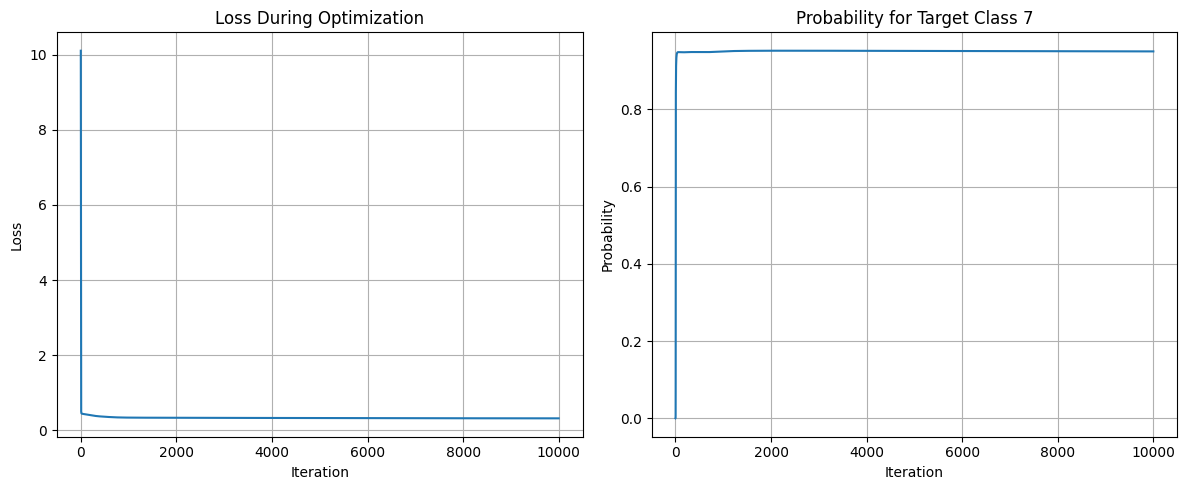

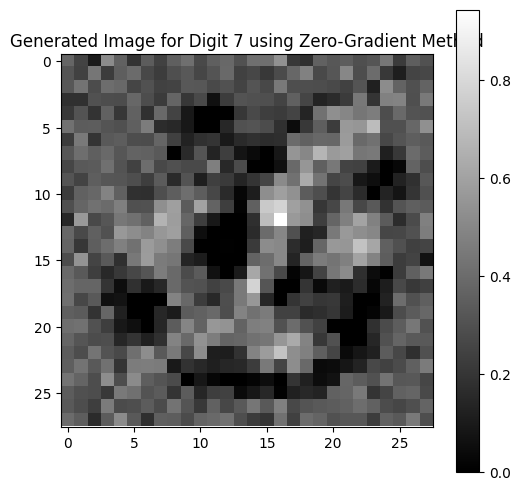

Generated image saved as zero_grad_digit_7_512x512.png

Verification - Network output for generated image:
Predicted digit: 7
Output probabilities:
[0.00502088 0.00483994 0.00585361 0.00573936 0.00522833 0.00595537
 0.00595593 0.95021378 0.00557445 0.00561834]


In [74]:
# Test the zero-gradient backpropagation approach for image generation
if nn is not None and training_history is not None:
    # Import necessary library for image manipulation (if not imported earlier)
    try:
        from PIL import Image
        pil_available = True
    except ImportError:
        print("Warning: PIL/Pillow library not available. Cannot save resized images.")
        pil_available = False
    
    # Set target digit and probability distribution
    target_digit = 7  # The digit we want to generate (0-9)
    high_prob = 0.95    # High probability for the target digit
    low_prob = (1.0 - high_prob) / (nn.output_size - 1)  # Distribution of remaining probability

    # Create target probability distribution
    target_vector = np.full((nn.output_size,), low_prob)
    target_vector[target_digit] = high_prob

    print(f"\n--- Generating image using Zero-Gradient Backpropagation ---")
    print(f"Target digit: {target_digit} with probability: {high_prob}")
    print(f"Target probabilities (sum={np.sum(target_vector):.2f}):\n{target_vector}")

    # Generate the image using zero-gradient backpropagation
    # Adjust hyperparameters as needed
    generated_image = generate_image_zero_gradient(
        network=nn,
        target_probabilities=target_vector,
        learning_rate=0.2,
        iterations=10000,
        regularization=0.0001,
        target_class=target_digit,
        verbose=True
    )

    if generated_image is not None:
        # Reshape to 28x28
        generated_image_28x28 = generated_image.reshape(28, 28)

        # Display the generated image
        plt.figure(figsize=(6, 6))
        plt.imshow(generated_image_28x28, cmap='gray')
        plt.title(f"Generated Image for Digit {target_digit} using Zero-Gradient Method")
        plt.colorbar()
        plt.show()

        # Save the resized image if PIL is available
        if pil_available:
            # Scale to 0-255 range for 8-bit image
            min_val, max_val = np.min(generated_image_28x28), np.max(generated_image_28x28)
            if max_val > min_val:
                normalized_image = (generated_image_28x28 - min_val) / (max_val - min_val)
            else:
                normalized_image = np.zeros_like(generated_image_28x28)

            image_data_scaled = (normalized_image * 255).astype(np.uint8)

            # Create and save image
            pil_image = Image.fromarray(image_data_scaled, mode='L')
            resized_image = pil_image.resize((512, 512), Image.Resampling.BICUBIC)
            output_filename = f'zero_grad_digit_{target_digit}_512x512.png'
            resized_image.save(output_filename)
            print(f"Generated image saved as {output_filename}")

        # Verify the generated image by passing it back through the network
        output_probs = nn.forward(generated_image.reshape(1, -1))
        print("\nVerification - Network output for generated image:")
        print(f"Predicted digit: {np.argmax(output_probs)}")
        print(f"Output probabilities:\n{output_probs.flatten()}")
else:
    print("Cannot test zero-gradient image generation because the network is not trained.")

## 10. Improved Zero-Gradient Image Generation for Clear Digits

In [77]:
def generate_improved_digit(network, target_digit, output_prob=0.9, learning_rate=0.05, 
                           iterations=5000, regularization=0.00001, use_sample_init=True, printLog = True):
    """Generate a clearer digit image using enhanced zero-gradient backpropagation.
    
    Args:
        network: The trained neural network
        target_digit: The digit to generate (0-9)
        output_prob: Target probability for the digit (default: 0.9)
        learning_rate: Learning rate for gradient descent (default: 0.05)
        iterations: Number of iterations (default: 5000)
        regularization: Regularization strength (default: 0.00001)
        use_sample_init: Whether to initialize from real samples (default: True)
        
    Returns:
        The generated image as a numpy array
    """
    if network is None:
        print("Error: Network not trained.")
        return None
    
    # Create target probability distribution
    other_prob = (1.0 - output_prob) / (network.output_size - 1)
    target_probs = np.full((1, network.output_size), other_prob)
    target_probs[0, target_digit] = output_prob
    
    if printLog:
        print(f"Generating improved image for digit {target_digit} with {output_prob} target probability")
        print(f"Using learning rate: {learning_rate}, iterations: {iterations}, reg: {regularization}")
    
    # Smart initialization - use average of real samples if available
    if use_sample_init and 'X_train' in globals() and 'y_train' in globals():
        # Find samples of the target digit
        y_train_digits = np.argmax(y_train, axis=1)
        digit_samples = X_train[y_train_digits == target_digit]
        
        if len(digit_samples) > 0:
            # Use average of first few samples with noise
            num_samples = min(10, len(digit_samples))
            image = np.mean(digit_samples[:num_samples], axis=0, keepdims=True)
            # Add small noise to break symmetry
            image += np.random.normal(0, 0.05, image.shape)
            # Ensure valid pixel range
            image = np.clip(image, 0.0, 1.0)
            print(f"Initialized with average of {num_samples} real samples of digit {target_digit}")
        else:
            # Fallback to random initialization
            image = np.random.uniform(0.4, 0.6, (1, network.input_size))
    else:
        # Random initialization in a good range for images
        image = np.random.uniform(0.4, 0.6, (1, network.input_size))
        
    # Track loss and probability history
    loss_history = []
    probability_history = []
    best_image = None
    best_loss = float('inf')
    
    # Implement cosine learning rate decay
    def get_lr(iteration):
        return learning_rate * (1 + np.cos(np.pi * iteration / iterations)) / 2
    
    # Optimization loop
    for i in range(iterations):
        # Current learning rate
        current_lr = get_lr(i)
        
        # Forward pass
        Z1 = image @ network.W1 + network.b1
        A1 = sigmoid(Z1)
        Z2 = A1 @ network.W2 + network.b2
        A2 = sigmoid(Z2)
        Z3 = A2 @ network.W3 + network.b3
        A3 = softmax(Z3)  # Output probabilities
        
        # Compute cross-entropy loss
        epsilon = 1e-9
        cross_entropy = -np.sum(target_probs * np.log(A3 + epsilon))
        
        # Add total variation regularization for spatial coherence
        img_2d = image.reshape(28, 28)
        tv_h = np.sum(np.abs(img_2d[:, 1:] - img_2d[:, :-1]))
        tv_v = np.sum(np.abs(img_2d[1:, :] - img_2d[:-1, :]))
        tv_reg = regularization * (tv_h + tv_v)
        
        # Add L2 regularization to avoid extreme values
        l2_reg = 0.00005 * np.sum(image ** 2)
        
        # Total loss
        loss = cross_entropy + tv_reg + l2_reg
        
        # Save history
        loss_history.append(loss)
        probability_history.append(A3[0, target_digit])
        
        # Save best image
        if loss < best_loss:
            best_loss = loss
            best_image = image.copy()
        
        # Backpropagation
        dZ3 = A3 - target_probs
        dA2 = dZ3 @ network.W3.T
        dZ2 = dA2 * sigmoid_derivative(A2)
        dA1 = dZ2 @ network.W2.T
        dZ1 = dA1 * sigmoid_derivative(A1)
        dImage = dZ1 @ network.W1.T
        
        # Add TV regularization gradient (approximation)
        tv_grad = np.zeros_like(image)
        if regularization > 0:
            img_2d_grad = np.zeros((28, 28))
            
            # Horizontal differences
            horiz_diff = np.sign(img_2d[:, 1:] - img_2d[:, :-1])
            img_2d_grad[:, 1:] += horiz_diff
            img_2d_grad[:, :-1] -= horiz_diff
            
            # Vertical differences
            vert_diff = np.sign(img_2d[1:, :] - img_2d[:-1, :])
            img_2d_grad[1:, :] += vert_diff
            img_2d_grad[:-1, :] -= vert_diff
            
            tv_grad = regularization * img_2d_grad.reshape(1, -1)
            
        # Add L2 regularization gradient
        l2_grad = 2 * 0.00005 * image
        
        # Update image
        total_gradient = dImage + tv_grad + l2_grad
        image -= current_lr * total_gradient
        
        # Ensure valid pixel range
        image = np.clip(image, 0.0, 1.0)
        
        # Print progress
        if printLog:
            if i % 500 == 0 or i == iterations-1:
                print(f"Iteration {i}/{iterations}, Loss: {loss:.4f}, "
                      f"Probability: {A3[0, target_digit]:.4f}, "
                      f"LR: {current_lr:.6f}")
    
    # Use best image found
    result_image = best_image.flatten()
    
    # Verify result
    output_probs = network.forward(best_image).flatten()
    print("\nFinal probabilities:")
    if printLog:
        for i, prob in enumerate(output_probs):
            print(f"  Digit {i}: {prob:.6f}" + (" <-- Target" if i == target_digit else ""))
    
    # Plot loss history

    if printLog:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss During Optimization')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(probability_history)
        plt.title(f'Probability for Digit {target_digit}')
        plt.xlabel('Iteration')
        plt.ylabel('Probability')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(result_image.reshape(28, 28), cmap='gray')
        plt.title(f"Improved Digit {target_digit} (Prob: {output_probs[target_digit]:.4f})")
        plt.colorbar()
        plt.show()
    
    # Save image
    try:
        from PIL import Image
        
        # Save original image
        img_data = result_image.reshape(28, 28)
        img_scaled = (img_data * 255).astype(np.uint8)
        img = Image.fromarray(img_scaled, mode='L')
        img_resized = img.resize((512, 512), Image.Resampling.BICUBIC)
        filename = f"improved_digit_{target_digit}.png"
        img_resized.save(filename)
        
        print(f"Saved image as {filename}")
    except ImportError:
        print("PIL not available - image not saved")
    
    return result_image.flatten()

Generating improved image for digit 7 with 0.95 target probability
Using learning rate: 0.001, iterations: 5000, reg: 5e-06
Initialized with average of 10 real samples of digit 7
Iteration 0/5000, Loss: 0.5324, Probability: 0.9898, LR: 0.001000
Iteration 500/5000, Loss: 0.5106, Probability: 0.9858, LR: 0.000976
Iteration 1000/5000, Loss: 0.4904, Probability: 0.9812, LR: 0.000905
Iteration 1500/5000, Loss: 0.4728, Probability: 0.9766, LR: 0.000794
Iteration 2000/5000, Loss: 0.4586, Probability: 0.9726, LR: 0.000655
Iteration 2500/5000, Loss: 0.4479, Probability: 0.9694, LR: 0.000500
Iteration 3000/5000, Loss: 0.4406, Probability: 0.9671, LR: 0.000345
Iteration 3500/5000, Loss: 0.4361, Probability: 0.9656, LR: 0.000206
Iteration 4000/5000, Loss: 0.4337, Probability: 0.9648, LR: 0.000095
Iteration 4500/5000, Loss: 0.4328, Probability: 0.9645, LR: 0.000024
Iteration 4999/5000, Loss: 0.4327, Probability: 0.9645, LR: 0.000000

Final probabilities:
  Digit 0: 0.000073
  Digit 1: 0.000040
  Di

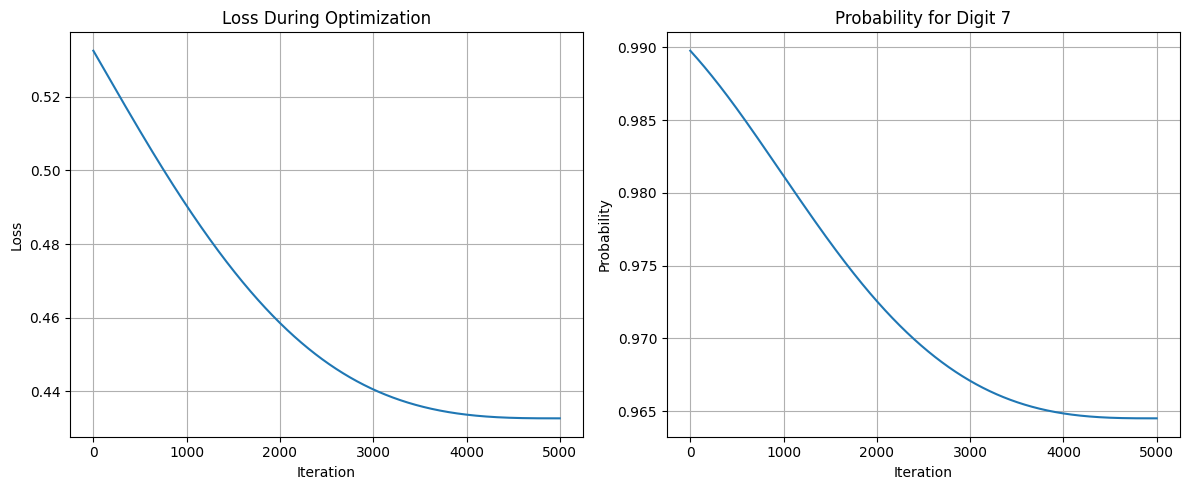

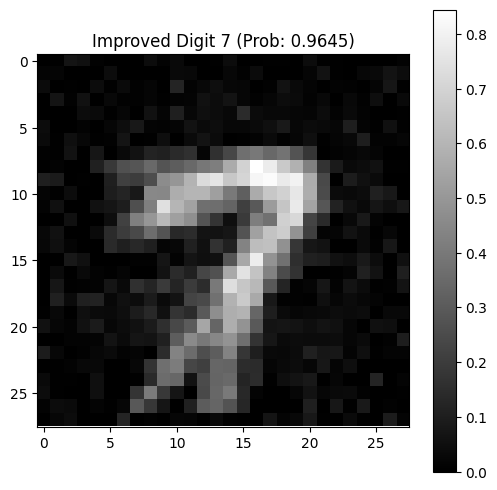

Saved image as improved_digit_7.png

Verification of improved digit 7:
Predicted digit: 7
Probability for digit 7: 0.964498


In [78]:
# Generate an improved digit 7
if nn is not None and training_history is not None:
    # Generate a clearer digit 7
    improved_digit_7 = generate_improved_digit(
        network=nn,
        target_digit=7,             # Generate digit 7
        output_prob=0.95,           # Higher target probability for more clarity
        learning_rate=0.001,         # Lower learning rate for more stability
        iterations=5000,            # More iterations for convergence
        regularization=0.000005,    # Very low regularization to allow clear features
        use_sample_init=True,
        printLog=True        # Initialize from real samples if available
    )
    
    # Verify the image through the network
    if improved_digit_7 is not None:
        output_probs = nn.forward(improved_digit_7.reshape(1, -1)).flatten()
        print(f"\nVerification of improved digit 7:")
        print(f"Predicted digit: {np.argmax(output_probs)}")
        print(f"Probability for digit 7: {output_probs[7]:.6f}")
else:
    print("Cannot generate improved digit because neural network is not trained.")

## 11. Comparing Different Digits with Various Target Probabilities

Generating 6 different digits with varied target probabilities
Using 2000 iterations for each digit

[1/6] Generating digit 0 with target prob 0.98...
Initialized with average of 10 real samples of digit 0

Final probabilities:
Saved image as improved_digit_0.png

[2/6] Generating digit 1 with target prob 0.98...
Initialized with average of 10 real samples of digit 1

Final probabilities:
Saved image as improved_digit_1.png

[3/6] Generating digit 3 with target prob 0.98...
Initialized with average of 10 real samples of digit 3

Final probabilities:
Saved image as improved_digit_3.png

[4/6] Generating digit 8 with target prob 0.98...
Initialized with average of 10 real samples of digit 8

Final probabilities:
Saved image as improved_digit_8.png

[5/6] Generating digit 9 with target prob 0.98...
Initialized with average of 10 real samples of digit 9

Final probabilities:
Saved image as improved_digit_9.png

[6/6] Generating digit 8 with target prob 0.5...
Initialized with average of 10

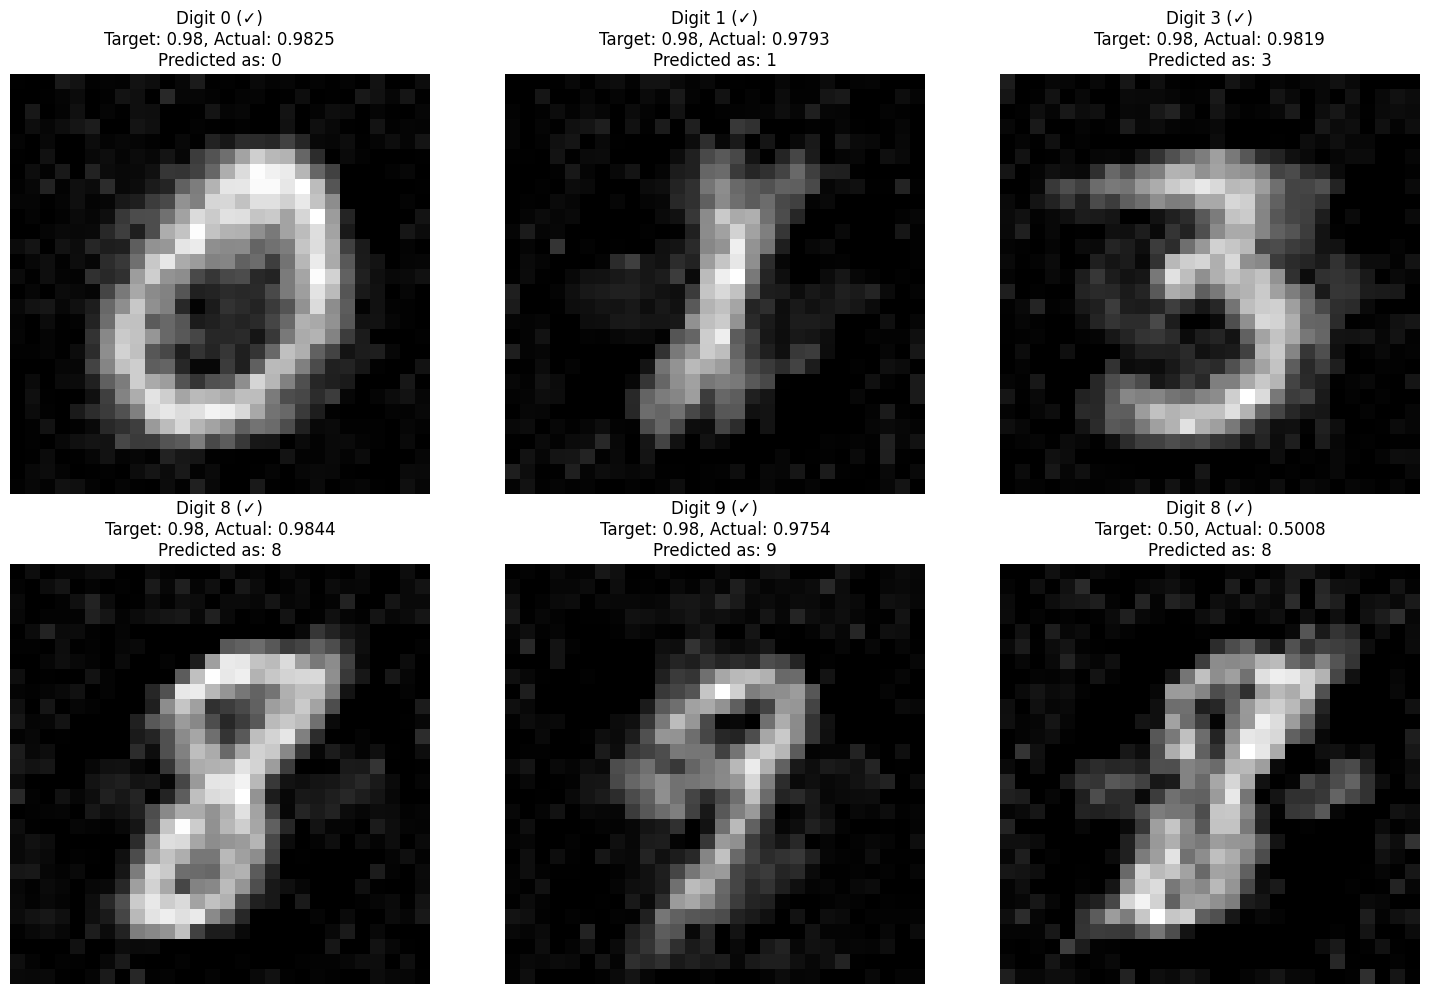

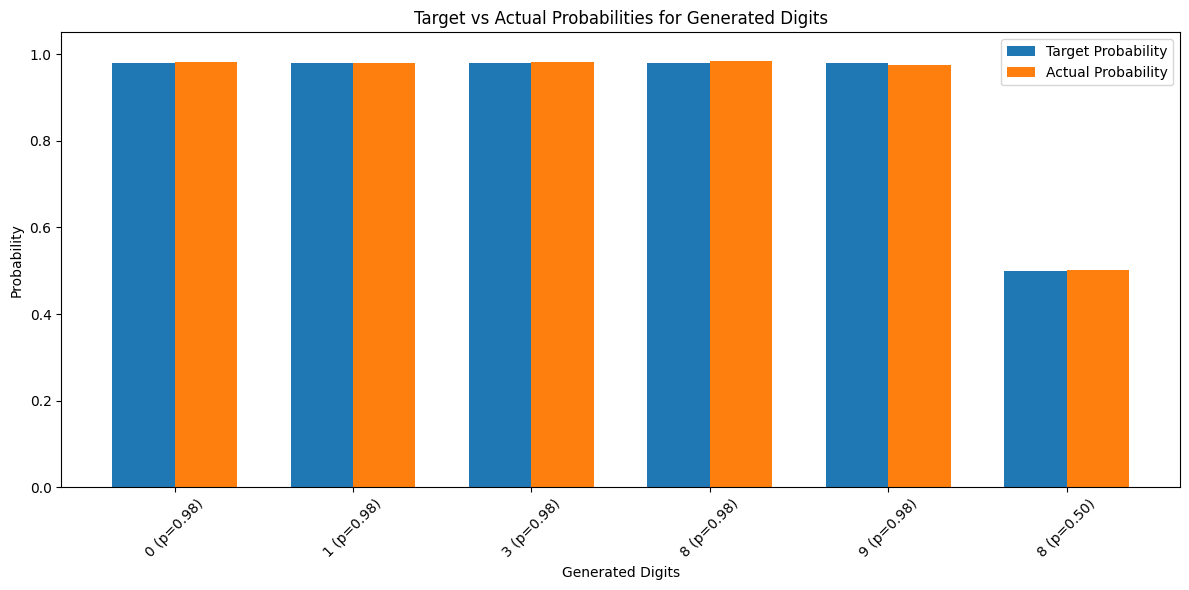

C:\Users\tarun\AppData\Local\Temp\ipykernel_7820\189574327.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


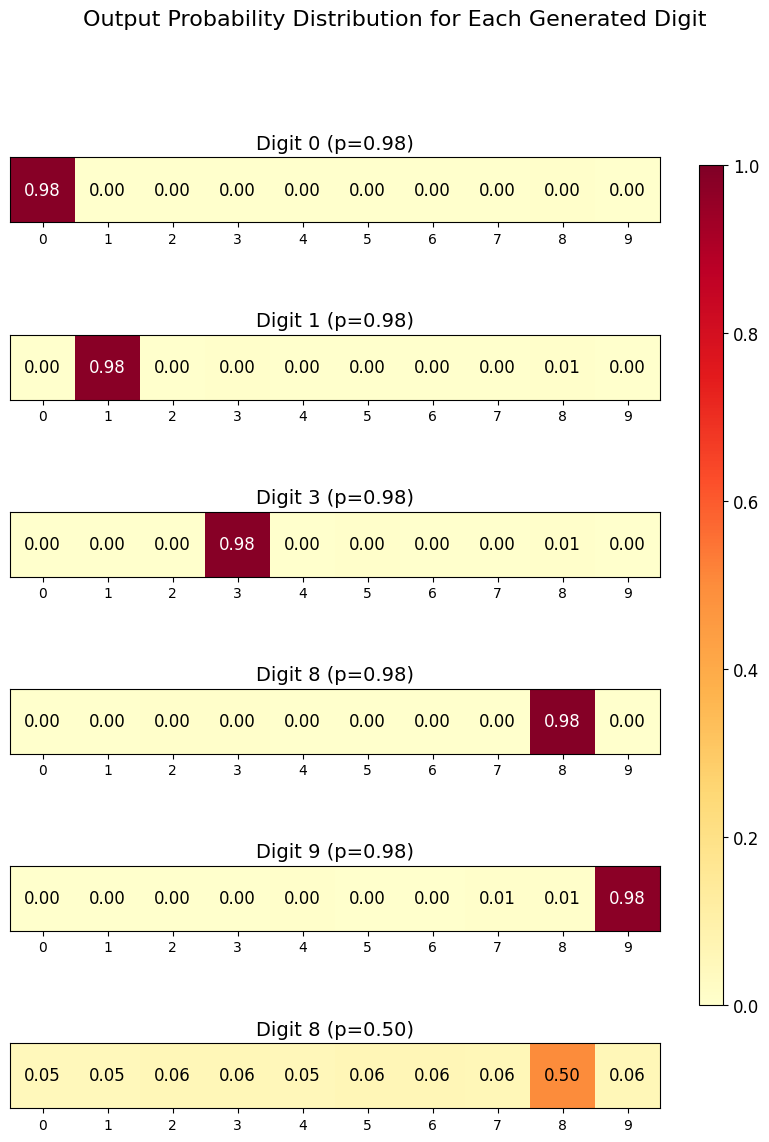

Saved digit comparison grid as digit_comparison_grid.png and digit_comparison_grid_large.png

----- Summary of Generated Digits -----
 Target  	Target Prob  	Actual Prob  	Predicted  	  Error    	Success 
------------------------------------------------------------------------------------------
   0     	   0.9800    	   0.9825    	    0      	  0.0025   	   ✓    
   1     	   0.9800    	   0.9793    	    1      	  0.0007   	   ✓    
   3     	   0.9800    	   0.9819    	    3      	  0.0019   	   ✓    
   8     	   0.9800    	   0.9844    	    8      	  0.0044   	   ✓    
   9     	   0.9800    	   0.9754    	    9      	  0.0046   	   ✓    
   8     	   0.5000    	   0.5008    	    8      	  0.0008   	   ✓    


In [79]:
# Compare multiple different digits with varied target probabilities using the improved approach
if nn is not None and training_history is not None:
    # Define digit-probability pairs to compare
    digit_config = [
        {'digit': 0, 'prob': 0.98},  # Digit 0 with high probability
        {'digit': 1, 'prob': 0.98},  # Digit 1 with high probability
        {'digit': 3, 'prob': 0.98},  # Digit 3 with high probability
        {'digit': 8, 'prob': 0.98},  # Digit 7 with high probability
        {'digit': 9, 'prob': 0.98},  # Digit 9 with high probability
        {'digit': 8, 'prob': 0.5}    # Digit 7 with lower probability for comparison
    ]
    
    # Configure generation parameters
    gen_config = {
        'learning_rate': 0.05,
        'iterations': 2000,     # Reduced for quicker comparison
        'regularization': 0.000008,
        'use_sample_init': True
    }
    
    print(f"Generating {len(digit_config)} different digits with varied target probabilities")
    print(f"Using {gen_config['iterations']} iterations for each digit")
    
    # Container to store results
    results = []
    
    # Generate each digit
    for i, config in enumerate(digit_config):
        print(f"\n[{i+1}/{len(digit_config)}] Generating digit {config['digit']} with target prob {config['prob']}...")
        
        # Use the improved digit generator function
        digit_image = generate_improved_digit(
            network=nn,
            target_digit=config['digit'],
            output_prob=config['prob'],
            learning_rate=gen_config['learning_rate'],
            iterations=gen_config['iterations'],
            regularization=gen_config['regularization'],
            use_sample_init=gen_config['use_sample_init'],
            printLog=False  # Disable verbose output for cleaner notebook
        )
        
        if digit_image is not None:
            # Verify through the network
            output_probs = nn.forward(digit_image.reshape(1, -1)).flatten()
            
            # Store result
            results.append({
                'target_digit': config['digit'],
                'target_prob': config['prob'],
                'image': digit_image.reshape(28, 28),
                'actual_prob': output_probs[config['digit']],
                'output_probs': output_probs,
                'predicted_digit': np.argmax(output_probs)
            })
    
    # Display all results in a grid
    if results:
        # Determine grid size
        n_cols = min(3, len(results))  # Max 3 columns
        n_rows = (len(results) + n_cols - 1) // n_cols
        
        # Create figure
        fig = plt.figure(figsize=(n_cols*5, n_rows*5))
        
        # Add each image to the grid
        for i, result in enumerate(results):
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            ax.imshow(result['image'], cmap='gray')
            
            # Create detailed title
            success = "✓" if result['predicted_digit'] == result['target_digit'] else "✗"
            title = f"Digit {result['target_digit']} ({success})\n" \
                   f"Target: {result['target_prob']:.2f}, Actual: {result['actual_prob']:.4f}\n" \
                   f"Predicted as: {result['predicted_digit']}"
            
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Create a bar chart comparing all probabilities
        plt.figure(figsize=(12, 6))
        x = np.arange(len(results))
        width = 0.35
        
        # Plot target vs actual probabilities
        plt.bar(x - width/2, [r['target_prob'] for r in results], width, label='Target Probability')
        plt.bar(x + width/2, [r['actual_prob'] for r in results], width, label='Actual Probability')
        
        # Add labels and legend
        plt.xlabel('Generated Digits')
        plt.ylabel('Probability')
        plt.title('Target vs Actual Probabilities for Generated Digits')
        plt.xticks(x, [f"{r['target_digit']} (p={r['target_prob']:.2f})" for r in results], rotation=45)
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Create heatmaps of output probabilities for each result
        fig, axs = plt.subplots(len(results), 1, figsize=(8, len(results)*2))
        plt.suptitle('Output Probability Distribution for Each Generated Digit', fontsize=16)

        for i, result in enumerate(results):
            # Create a heatmap showing all output probabilities
            im = axs[i].imshow(
                result['output_probs'].reshape(1, -1), 
                cmap='YlOrRd', 
                vmin=0, 
                vmax=1
            )
            
            # Add text annotations for probabilities
            for j in range(10):
                text_color = 'black' if result['output_probs'][j] < 0.6 else 'white'
                axs[i].text(
                    j, 0, 
                    f"{result['output_probs'][j]:.2f}", 
                    ha='center', 
                    va='center', 
                    color=text_color,
                    fontsize=12
                )
            
            # Formatting
            axs[i].set_xticks(range(10))
            axs[i].set_xticklabels(range(10))
            axs[i].set_yticks([])
            axs[i].set_title(f"Digit {result['target_digit']} (p={result['target_prob']:.2f})", fontsize=14)

        # Add colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)

        plt.tight_layout(rect=[0, 0, 0.85, 0.95])
        plt.show()
        
        # Save the results as a grid of images
        try:
            from PIL import Image
            
            # Calculate grid dimensions
            grid_size = (28*n_cols, 28*n_rows)
            grid = Image.new('L', grid_size, color=255)
            
            # Add each image to the grid
            for i, result in enumerate(results):
                row = i // n_cols
                col = i % n_cols
                
                # Normalize and convert to uint8
                img_data = result['image']
                min_val, max_val = np.min(img_data), np.max(img_data)
                normalized = (img_data - min_val) / (max_val - min_val) if max_val > min_val else img_data
                img_bytes = (normalized * 255).astype(np.uint8)
                
                # Create and paste the image
                digit_img = Image.fromarray(img_bytes, mode='L')
                grid.paste(digit_img, (col*28, row*28))
            
            # Save the grid and a resized version
            grid_filename = "digit_comparison_grid.png"
            grid.save(grid_filename)
            
            # Save a larger version
            large_grid = grid.resize((grid_size[0]*4, grid_size[1]*4), Image.Resampling.BICUBIC)
            large_grid_filename = "digit_comparison_grid_large.png"
            large_grid.save(large_grid_filename)
            
            print(f"Saved digit comparison grid as {grid_filename} and {large_grid_filename}")
        except ImportError:
            print("PIL not available - could not save image grid")
        
        # Print summary of results
        print("\n----- Summary of Generated Digits -----")
        print(f"{'Target':^8} \t{'Target Prob':^12} \t{'Actual Prob':^12} \t{'Predicted':^10} \t{'Error':^10} \t{'Success':^8}")
        print("-" * 90)
        
        for result in results:
            target = result['target_digit']
            target_prob = result['target_prob']
            actual_prob = result['actual_prob']
            predicted = result['predicted_digit']
            error = abs(target_prob - actual_prob)
            success = "✓" if predicted == target else "✗"
            
            print(f"{target:^8d} \t{target_prob:^12.4f} \t{actual_prob:^12.4f} \t{predicted:^10d} \t{error:^10.4f} \t{success:^8}")
else:
    print("Cannot run multi-digit comparison because the neural network is not trained.")

## 12. Custom Digit Comparison

Generating 10 digits with target probability 0.95...

[1/10] Generating digit 0...
Initialized with average of 10 real samples of digit 0

Final probabilities:
Saved image as improved_digit_0.png

[2/10] Generating digit 1...
Initialized with average of 10 real samples of digit 1

Final probabilities:
Saved image as improved_digit_1.png

[3/10] Generating digit 2...
Initialized with average of 10 real samples of digit 2

Final probabilities:
Saved image as improved_digit_2.png

[4/10] Generating digit 3...
Initialized with average of 10 real samples of digit 3

Final probabilities:
Saved image as improved_digit_3.png

[5/10] Generating digit 4...
Initialized with average of 10 real samples of digit 4

Final probabilities:
Saved image as improved_digit_4.png

[6/10] Generating digit 5...
Initialized with average of 10 real samples of digit 5

Final probabilities:
Saved image as improved_digit_5.png

[7/10] Generating digit 6...
Initialized with average of 10 real samples of digit 6

Fin

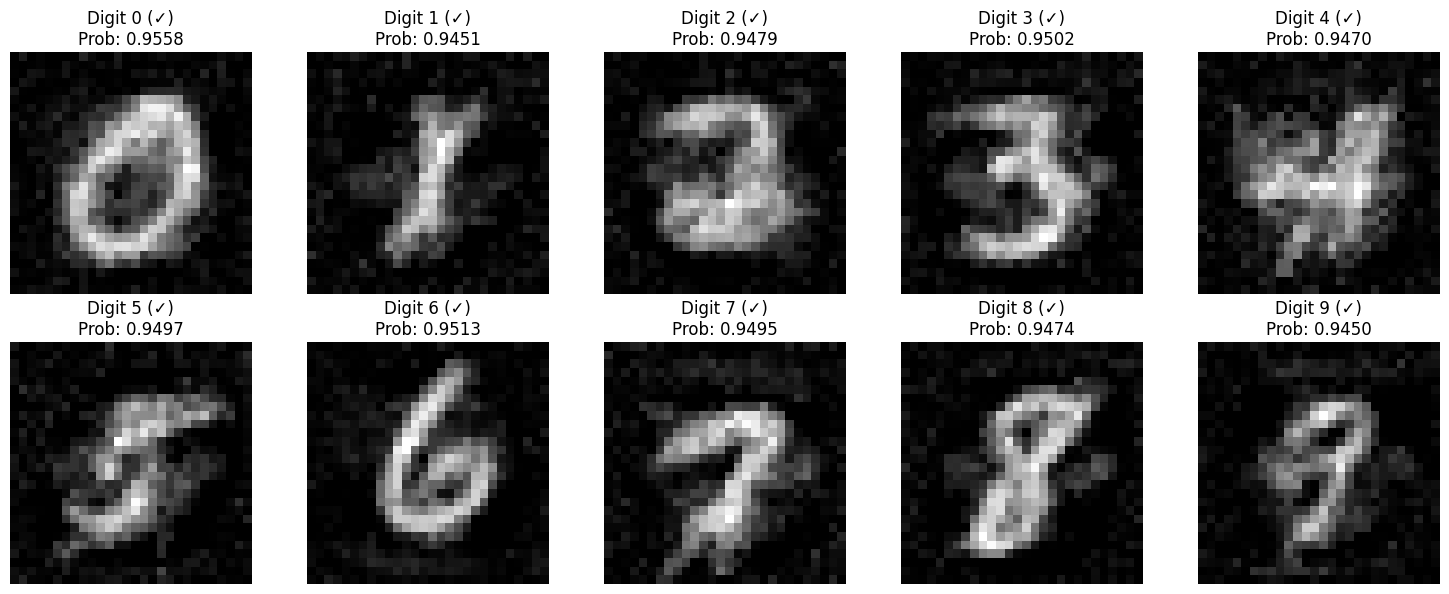


Successfully generated 10 out of 10 digits
Average probability error: 0.002587
Saved all digits as all_digits_grid.png


In [81]:
# Function to easily generate multiple digits with custom settings
def compare_digits(digits, probability=0.98, iterations=3000, learning_rate=0.05, regularization=0.000005):
    """Generate and compare multiple digits with the same settings.
    
    Args:
        digits: List of digits to generate (0-9)
        probability: Target probability for all digits
        iterations: Number of iterations for generation
        learning_rate: Learning rate for optimization
        regularization: Regularization strength
        
    Returns:
        List of generated digit images and their results
    """
    if nn is None or training_history is None:
        print("Neural network not trained. Cannot generate digits.")
        return None
    
    results = []
    
    print(f"Generating {len(digits)} digits with target probability {probability}...")
    
    for i, digit in enumerate(digits):
        print(f"\n[{i+1}/{len(digits)}] Generating digit {digit}...")
        
        img = generate_improved_digit(
            network=nn,
            target_digit=digit,
            output_prob=probability,
            iterations=iterations,
            learning_rate=learning_rate,
            regularization=regularization,
            use_sample_init=True,
            printLog=False  # Disable verbose output for cleaner notebook
        )
        
        if img is not None:
            output_probs = nn.forward(img.reshape(1, -1)).flatten()
            results.append({
                'digit': digit,
                'image': img.reshape(28, 28),
                'probs': output_probs,
                'target_prob': probability,
                'actual_prob': output_probs[digit],
                'predicted': np.argmax(output_probs)
            })
    
    # Display results
    if results:
        # Create a grid of images
        cols = min(5, len(results))
        rows = (len(results) + cols - 1) // cols
        
        plt.figure(figsize=(cols*3, rows*3))
        for i, res in enumerate(results):
            plt.subplot(rows, cols, i+1)
            plt.imshow(res['image'], cmap='gray')
            
            # Create title with prediction info
            success = "✓" if res['predicted'] == res['digit'] else "✗"
            plt.title(f"Digit {res['digit']} ({success})\nProb: {res['actual_prob']:.4f}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
    
    return results

# Example usage
if nn is not None and training_history is not None:
    # Generate all digits from 0 to 9 with the same settings
    all_digits_results = compare_digits(
        digits=list(range(10)),  # Generate all digits 0-9
        probability=0.95,        # Target probability 
        iterations=2500,         # Number of iterations
        learning_rate=0.04,      # Learning rate
        regularization=0.000007  # Regularization strength
    )
    
    if all_digits_results:
        # Count successful generations
        success_count = sum(1 for r in all_digits_results if r['predicted'] == r['digit'])
        print(f"\nSuccessfully generated {success_count} out of {len(all_digits_results)} digits")
        
        # Calculate average probability error
        avg_error = np.mean([abs(r['actual_prob'] - r['target_prob']) for r in all_digits_results])
        print(f"Average probability error: {avg_error:.6f}")
        
        # Save as a single high-res image
        try:
            from PIL import Image
            
            # Create a grid
            cols = min(5, len(all_digits_results))
            rows = (len(all_digits_results) + cols - 1) // cols
            cell_size = 28 * 4  # Each digit is 28x28, scale by 4
            
            # Create a new blank image
            grid = Image.new('L', (cols * cell_size, rows * cell_size), 255)
            
            # Add each digit to the grid
            for i, res in enumerate(all_digits_results):
                # Normalize and convert to uint8
                img_data = res['image']
                min_val, max_val = np.min(img_data), np.max(img_data)
                if max_val > min_val:
                    normalized = (img_data - min_val) / (max_val - min_val)
                else:
                    normalized = np.zeros_like(img_data)
                
                img_bytes = (normalized * 255).astype(np.uint8)
                img = Image.fromarray(img_bytes, 'L')
                img_resized = img.resize((cell_size, cell_size), Image.Resampling.BICUBIC)
                
                # Calculate position
                row, col = divmod(i, cols)
                grid.paste(img_resized, (col * cell_size, row * cell_size))
            
            # Save the grid
            filename = "all_digits_grid.png"
            grid.save(filename)
            print(f"Saved all digits as {filename}")
        except ImportError:
            print("PIL not available - could not save image")
else:
    print("Cannot run example because neural network is not trained.")